In [7]:
# Algorithme complet avec définition des classes

# Importation des modules necessaires
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import statistics
from timeit import default_timer as timer

# La classe Graphe contient les donnees globale du swarm : le maximum globale, le nombre de particule, la matrice d'adjacence
# Il contient aussi la liste des particules qui lui sont attribuees
# Les methodes de la classe sont des outils pour faire fonctionner l'algorithme contenu dans la fonction "colors"
class Graphe :
    
    # Initialisation des attributs du graphe
    def __init__(self,R):
        self.R = R
        self.dim = len(R)
        self.particles = []
        self.tu = False
        self.Pg = False
    
    # Cree N particules de positions et velocites aleatoires dans les bons espaces
    def create_particles(self,N):
        for k in range(N):
            #creation des vecteurs positions et velocites
            v = np.random.random(self.dim)
            x = np.random.randint(4, size=self.dim)
            #ajout d'une particule a la liste de particules du graphe
            self.particles = np.append(self.particles, Particle(x,v))

    # Met a jour l'ensemble des particules selon l'algorithme
    def update_particles(self,w,Pg,c1,c2,fit):
        N = len(self.particles)
        for k in range(N):
            self.particles[k].update(w,Pg,c1,c2,fit)
    
    # Met a jour des attributs du graphe
    def update_graphe(self,t,fit):
        for x in self.particles :
            
            if type(self.Pg) == bool :
                self.Pg = x.pi
            if fit(x.pi)< fit(self.Pg) :
                self.Pg = x.pi
                self.tu = t
    
    # Appelle le reinitialisation des velocites des particules
    def reset_particles(self):
        for x in self.particles :
            x.reset()

    # Fais tourner l'algorithme de coloration
    # Retourne le nombre de conflit de couleur de la solution obtenue, le nombre d'iterations, et le graphique colore.
    def colors(self,M,N):
        # On initialise les parametres necessaires
        u = 10 
        # Poids des x.pi, x.Pg, et de la part d'aleatoire dans les mises a jour des particules
        w = 2
        c1 = 2
        c2 = 1.8
        
        #on cree le bon nombre de particules
        self.create_particles(N)
        
        #On definit la fonction fitness, qui compte le nombre de conflits de couleurs pour une solution donnee
        def fit(x):
            conflits = 0
            for i in range(self.dim):
                for j in range(i+1,self.dim):
                    if self.R[i][j] == 1 :
                        if x[i] == x[j] :
                            conflits += 1
            
            
            return(conflits)
        
        # Tant que la solution optimale n'a pas ete trouvee, et que le nombre maximale d'iteration n'a pas ete atteint
        t=1 # Nombre d'iterations
        self.update_graphe(t,fit)
        while fit(self.Pg)!= 0 and t<=M:
            t+=1
            
            # On met a jour les positions des particules, et les attributs du graphe
            self.update_particles(w,self.Pg,c1,c2,fit)
            self.update_graphe(t,fit)
            
            # Si la meilleur solution n'evolue pas, on reinitialise aleatoirement les velocites
            if (t - self.tu > u) :
                self.reset_particles()
        
        # Trace la solution finale obtenue par l'algorithme, en colorant les noeuds dans leur couleur attribuee
        # A décommenter si nécessaire.
        
#         color_map =[]
#         for i in range(len(self.Pg)) :
#             if self.Pg[i] == 0 :
#                 color_map.append('red')
#             elif self.Pg[i] == 1 :
#                 color_map.append('blue')
#             elif self.Pg[i] == 2 :
#                 color_map.append('yellow')
#             elif self.Pg[i] == 3 :
#                 color_map.append('green')
        
#         Gr = nx.from_numpy_matrix(self.R)
#         nx.draw(Gr, node_color=color_map, with_labels=True)
#         plt.show()
        
        return(fit(self.Pg), t)
# --------------------------------------------------------
# La classe Particle contient les donnees connues par la particule : sa position, sa velocite et sa meilleur performance
# Les methodes de la particule servent a mettre a jour sa position en fonction de sa velocite, et a gerer sa memoire
# Elles sont appelees par la classe Graphe qui detient un certain nombre de particules.
class Particle ():
    # Initialisation des attributs de la particule
    def __init__(self, x, v):
        self.x = x
        self.v = v
        
        self.pi = x
    
    # Mise a jour des coordonnees de la particule selon l'algorithme modified PSO
    def update(self, w, Pg, c1, c2, fit):
        
        # Mise a jour de la velocite
        self.v = w*self.v + c1*np.random.random()*(self.pi-self.x) + c2*np.random.random()*(Pg-self.x)
        
        # Fonction sigmoide
        def S(v):
            return 1/(1+np.exp(-v))
        
        # Fonction aleatoire caracteristique de la quaternary PSO
        def f(v,r):
            resultat = []
            for i in range(len(v)):
                elt = v[i]
                rdm = np.random.random()
                if (rdm>r and rdm<S(elt)):
                    resultat.append(0)
                if (rdm<r and rdm<S(elt)):
                    resultat.append(1)
                if (rdm<=r and rdm>=S(elt)):
                    resultat.append(2)
                if (rdm>=r and rdm>=S(elt)):
                    resultat.append(3)
            return(resultat)
        
        # Mise a jour de la position
        self.x = (self.x + f(self.v,0.5))%4
        
        # Memorisation de la position en cas de meilleur performance
        if (fit(self.pi)>fit(self.x)):
            self.pi = self.x

    # Reinitialisation de la vitesse
    def reset(self):
        n = len(self.v)
        self.v = np.random.random(n)

In [12]:
# Generation d'un graphe aleatoire, jusqu'a ce qu'il soit planaire
# Utilisation de la condition e < 3n-6 pour optimiser les probablités de génération d'un graphe planaire

def generation_graphe_plan(n):
    start = timer()
    test = False
    debug = 0 # relance un jet du nombre d'arêtes à générer si l'algorithme met trop de temps
              # cela réduit la probabilité d'avoir un haut nombre d'arêtes, mais elle reste décente...
              # c'est un choix pour rendre le temps d'execution abordable pour réaliser des tests
    
    if n>3 :
        u = 3*n-6
        min_ar = 2*n-7    #nombre minimal d'arete
        m = np.random.randint(min_ar,u)
    
    while not (test) :
        if n <=3 :
            P = np.random.randint(0,2,(n,n)) - np.identity(n)
            P = (P + np.transpose(P))/2
            P[P > 1 ] = 1
            P[P < 1 ] = 0
            G = nx.from_numpy_matrix(P)
            test = nx.check_planarity(G)[0]

        elif n>3:
            debug +=1
            # Condition nécessaire à la génération d'un graphe plan
            G = nx.gnm_random_graph(n, m, seed=None, directed=False)
            test = nx.check_planarity(G)[0]
            if debug > 5*n :
                m = np.random.randint(min_ar,u)
                debug = 0
            
    # Recuperation de la matrice d'adjacence du graphe
    end = timer()
    
    generation_time = end-start
        
    P = nx.to_numpy_array(G)
    return(P,generation_time)


In [13]:
# Application de l'algorithme après generation d'un graphe planaire aleatoire

start = timer()

n = 15      # Nombre de noeuds du graphe
M = 10000   # Nombre maximum d'iterations pour l'algorithme
N = 100     # Nombre de particule utilisees pour l'algorithme

P,generation_time = generation_graphe_plan(n)

print('temps de génération :',generation_time)
print("Lancement de l'algorithme")
start = timer()

# Application de l'algorithme
G = Graphe(P)
res,t = G.colors(M,N)

end = timer()
print("temps d'execution :",end - start)
print("nombre d'iterations :",t)
print("nombre de conflit :",res)

temps de génération : 0.0013393000000405664
Lancement de l'algorithme


d:\logiciels_divers\miniconda\miniconda_intallation\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in exp


temps d'execution : 1.7332313000000568
nombre d'iterations : 43
nombre de conflit : 0


In [14]:
# Application de l'algorithme à plusieurs graphes pour plusieurs nombres de noeuds afin de tracer des statistiques

M = 10000   # Nombre maximum d'iterations pour l'algorithme
N = 10     # Nombre de particule utilisees pour l'algorithme

nbr_noeuds = [10,11,12,13]     # Nombre de noeuds des graphes
nb_graph = 10               # Nombre de graphe à générer par nombre de noeuds 

# Tableaux pour stocker les valeurs
tps_generation = []
tps_generation = []
nbr_iterations = []
nbr_conflits = []


for n in nbr_noeuds:
    # Listes contenant les valeurs pour le nombre de noeuds n
    tps_generation_n = []
    nbr_iterations_n = []
    nbr_conflits_n = []
    tps_execution_n = []
    
    for i in range(nb_graph):
        # Génération d'un graphe
        P,tps_gene = generation_graphe_plan(n)
        # Application de l'algorithme
        start = timer()
        G = Graphe(P)
        conflits,iterations = G.colors(M,N)
        end = timer()
        tp_algo = end-start
        # Ajout des données du graphe généré à la liste des données pour le nombre de noeuds n
        tps_generation_n.append(tps_gene)
        nbr_conflits_n.append(conflits)
        nbr_iterations_n.append(iterations)
        tps_execution_n.append(tp_algo)
    
    # Ajout de l'ensemble des données pour le nombre de noeuds n au tableau de stockage général
    tps_generation.append(tps_generation_n)
    nbr_iterations.append(nbr_iterations_n)
    nbr_conflits.append(nbr_conflits_n)

# Calculs des différentes valeurs à afficher
# temps d'execution
maxs = []
mins = []
moyennes = []
# taux d'erreurs
conflits = []
# temps de génération 
generations_moy = []

# nombre maximal d'itération, nombre minimal, moyenne, taux d'erreurs 
for i in range(len(nbr_noeuds)):
    maxs.append(max(nbr_iterations[i]))
    mins.append(min(nbr_iterations[i]))
    moyennes.append(statistics.mean(nbr_iterations[i]))
    conflits.append(statistics.mean(nbr_conflits[i]))
    generations_moy.append(statistics.mean(tps_generation[i]))

# Affichage des données (prise manuelle pour faire des tableaux plus jolis pour le rapport)

for i in range(len(nbr_noeuds)):
    print('n :', nbr_noeuds[i])
    print('min :',mins[i])
    print('max :', maxs[i])
    print('moy :', moyennes[i])
    print('conf :', conflits[i])
    print('gene :', generations_moy[i])
    print('------------')




d:\logiciels_divers\miniconda\miniconda_intallation\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in exp


n : 10
min : 1
max : 156
moy : 43.2
conf : 0
gene : 0.011956919999977344
------------
n : 11
min : 5
max : 297
moy : 85.1
conf : 0
gene : 0.01665662999998858
------------
n : 12
min : 5
max : 550
moy : 128.3
conf : 0
gene : 0.015847439999981817
------------
n : 13
min : 4
max : 1215
moy : 278.6
conf : 0
gene : 0.0573880000000031
------------


In [15]:
# Calculs des différentes valeurs à afficher
# temps d'execution
maxs = []
mins = []
moyennes = []
# taux d'erreurs
conflits = []
# temps de génération 
generations_moy = []
# nombre maximal d'itération, nombre minimal, moyenne, taux d'erreurs 
for i in range(len(nbr_noeuds)-1):
    maxs.append(max(nbr_iterations[i]))
    mins.append(min(nbr_iterations[i]))
    moyennes.append(statistics.mean(nbr_iterations[i]))
    conflits.append(statistics.mean(nbr_conflits[i]))
    generations_moy.append(statistics.mean(tps_generation[i]))
    
    # Affichage des données (prise manuelle pour faire des tableaux plus jolis pour le rapport)
    print('n :', nbr_noeuds[i])
    print('min :',mins[i])
    print('max :', maxs[i])
    print('moy :', moyennes[i])
    print('conf :', conflits[i])
    print('gene :', generations_moy[i])



n : 10
min : 1
max : 156
moy : 43.2
conf : 0
gene : 0.011956919999977344
n : 11
min : 5
max : 297
moy : 85.1
conf : 0
gene : 0.01665662999998858
n : 12
min : 5
max : 550
moy : 128.3
conf : 0
gene : 0.015847439999981817


Graphe genere
Lancement de l'algorithme
(0, 5)


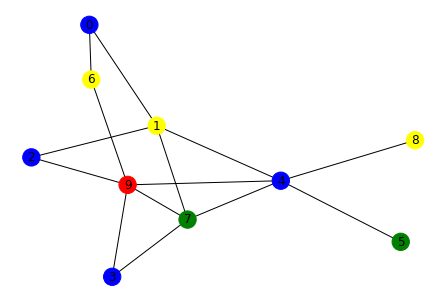

In [16]:
# Test cell du fichier complet

# Importation des modules necessaires
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import statistics
from timeit import default_timer as timer

# La classe Graphe contient les donnees globale du swarm : le maximum globale, le nombre de particule, la matrice d'adjacence
# Il contient aussi la liste des particules qui lui sont attribuees
# Les methodes de la classe sont des outils pour faire fonctionner l'algorithme contenu dans la fonction "colors"
class Graphe :
    
    # Initialisation des attributs du graphe
    def __init__(self,R):
        self.R = R
        self.dim = len(R)
        self.particles = []
        self.tu = False
        self.Pg = False
    
    # Cree N particules de positions et velocites aleatoires dans les bons espaces
    def create_particles(self,N):
        for k in range(N):
            #creation des vecteurs positions et velocites
            v = np.random.random(self.dim)
            x = np.random.randint(4, size=self.dim)
            #ajout d'une particule a la liste de particules du graphe
            self.particles = np.append(self.particles, Particle(x,v))

    # Met a jour l'ensemble des particules selon l'algorithme
    def update_particles(self,w,Pg,c1,c2,fit):
        N = len(self.particles)
        for k in range(N):
            self.particles[k].update(w,Pg,c1,c2,fit)
    
    # Met a jour des attributs du graphe
    def update_graphe(self,t,fit):
        for x in self.particles :
            
            if type(self.Pg) == bool :
                self.Pg = x.pi
            if fit(x.pi)< fit(self.Pg) :
                self.Pg = x.pi
                self.tu = t
    
    # Appelle le reinitialisation des velocites des particules
    def reset_particles(self):
        for x in self.particles :
            x.reset()

    # Fais tourner l'algorithme de coloration
    # Retourne le nombre de conflit de couleur de la solution obtenue, le nombre d'iterations, et le graphique colore.
    def colors(self,M,N):
        # On reinitialise les particules si elles existent :
        self.particles = []
        self.Pg = False
        # On initialise les parametres necessaires
        u = 10 
        # Poids des x.pi, x.Pg, et de la part d'aleatoire dans les mises a jour des particules
        w = 2
        c1 = 2
        c2 = 1.8
        
        #on cree le bon nombre de particules
        self.create_particles(N)
        
        #On definit la fonction fitness, qui compte le nombre de conflits de couleurs pour une solution donnee
        def fit(x):
            conflits = 0
            for i in range(self.dim):
                for j in range(i+1,self.dim):
                    if self.R[i][j] == 1 :
                        if x[i] == x[j] :
                            conflits += 1
            
            
            return(conflits)
        
        # Tant que la solution optimale n'a pas ete trouvee, et que le nombre maximale d'iteration n'a pas ete atteint
        t=0 # Nombre d'iterations
        self.update_graphe(t,fit)
        while fit(self.Pg)!= 0 and t<=M:
            t+=1
            
            # On met a jour les positions des particules, et les attributs du graphe
            self.update_particles(w,self.Pg,c1,c2,fit)
            self.update_graphe(t,fit)
            
            # Si la meilleur solution n'evolue pas, on reinitialise aleatoirement les velocites
            if (t - self.tu > u) :
                self.reset_particles()
        
        # Trace la solution finale obtenue par l'algorithme, en colorant les noeuds dans leur couleur attribuee
        color_map =[]
        for i in range(len(self.Pg)) :
            if self.Pg[i] == 0 :
                color_map.append('red')
            elif self.Pg[i] == 1 :
                color_map.append('blue')
            elif self.Pg[i] == 2 :
                color_map.append('yellow')
            elif self.Pg[i] == 3 :
                color_map.append('green')
        
        Gr = nx.from_numpy_matrix(self.R)
        pos=nx.spring_layout(Gr)
        
        print((fit(self.Pg), t))
        
        nx.draw(Gr, node_color=color_map, with_labels=True)
        plt.show()
        
        
# --------------------------------------------------------
# La classe Particle contient les donnees connues par la particule : sa position, sa velocite et sa meilleur performance
# Les methodes de la particule servent a mettre a jour sa position en fonction de sa velocite, et a gerer sa memoire
# Elles sont appelees par la classe Graphe qui detient un certain nombre de particules.
class Particle ():
    # Initialisation des attributs de la particule
    def __init__(self, x, v):
        self.x = x
        self.v = v
        
        self.pi = x
    
    # Mise a jour des coordonnees de la particule selon l'algorithme modified PSO
    def update(self, w, Pg, c1, c2, fit):
        
        # Mise a jour de la velocite
        self.v = w*self.v + c1*np.random.random()*(self.pi-self.x) + c2*np.random.random()*(Pg-self.x)
        
        # Fonction sigmoide
        def S(v):
            return 1/(1+np.exp(-v))
        
        # Fonction aleatoire caracteristique de la quaternary PSO
        def f(v,r):
            resultat = []
            for i in range(len(v)):
                elt = v[i]
                rdm = np.random.random()
                if (rdm>r and rdm<S(elt)):
                    resultat.append(0)
                if (rdm<r and rdm<S(elt)):
                    resultat.append(1)
                if (rdm<=r and rdm>=S(elt)):
                    resultat.append(2)
                if (rdm>=r and rdm>=S(elt)):
                    resultat.append(3)
            return(resultat)
        
        # Mise a jour de la position
        self.x = (self.x + f(self.v,0.5))%4
        
        # Memorisation de la position en cas de meilleur performance
        if (fit(self.pi)>fit(self.x)):
            self.pi = self.x

    # Reinitialisation de la vitesse
    def reset(self):
        n = len(self.v)
        self.v = np.random.random(n)
        
        
if __name__ == '__main__' :        
    # Application de l'algorithme après generation d'un graphe plan aleatoire
    np.random.seed(6)

    n = 10      # Nombre de noeuds du graphe
    M = 10000   # Nombre maximum d'iterations pour l'algorithme
    N = 10     # Nombre de particule utilisees pour l'algorithme

    # Generation d'un graphe aleatoire, jusqu'a ce qu'il soit planaire
    # Remarque : 
    # Aucune methode plus efficace de generation de graphe planaire aleatoire n'a ete trouvee 
    # Pour un petit nombre de noeud (<50) cette methode reste satisfaisante
    test = False
    while not (test) :
        P = np.random.randint(0,2,(n,n)) - np.identity(n)
        P = (P + np.transpose(P))/2
        P[P > 1 ] = 1
        P[P < 1 ] = 0

        G = nx.from_numpy_matrix(P)
        test = nx.check_planarity(G)[0]

    print('Graphe genere')
    print("Lancement de l'algorithme")
    # Recuperation de la matrice d'adjacence du graphe
    P = nx.to_numpy_array(G)

    # Application de l'algorithme
    G = Graphe(P)
    G.colors(M,N)

d:\logiciels_divers\miniconda\miniconda_intallation\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


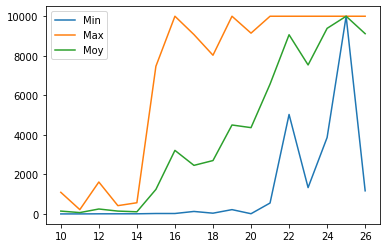

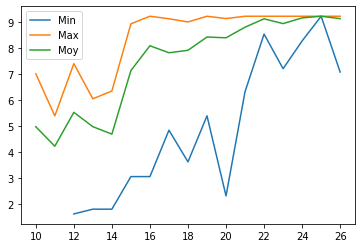

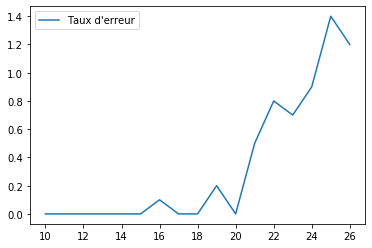

d:\logiciels_divers\miniconda\miniconda_intallation\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


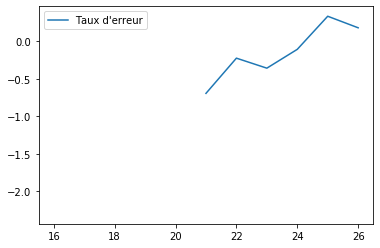

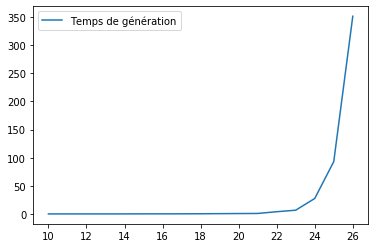

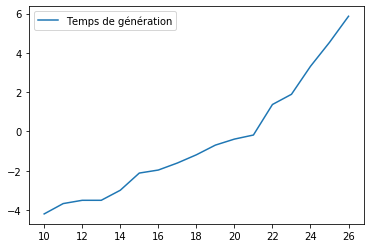

In [17]:
import matplotlib.pyplot as plt

# Données récupérées précédemment, mais par morceaux (le programme met trop de temps à tourner quand on augmente le nombre de données)
nodes = [10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
mins = [0,0,5,6,6,21,21,125,37,217,10,551,5031,1331,3866,10000,1169]
maxs = [1093,217,1614,418,565,7470,10000,9073,8028,10000,9145,10000,10000,10000,10000,10000,10000]
moy = [142.9,67.5,248.5,143.1,107.6,1239.3,3213.6,2455.9,2699.4,4498.7,4364.6,6566.1,9063.5,7536.3,9387.5,10000,9117.8]
conflits = [0,0,0,0,0,0,0.1,0,0,0.2,0,0.5,0.8,0.7,0.9,1.4,1.2]
tps_gene = [0.015,0.0254,0.03,0.03,0.05,0.12,0.14,0.20,0.304,0.498,0.676,0.832,3.936,6.613,27.48659,93.06,351.6]

plt.figure()
plt.plot(nodes,mins,label = 'Min')
plt.plot(nodes,maxs,label = 'Max')
plt.plot(nodes, moy,label = 'Moy')
plt.legend()
plt.show

plt.figure()
plt.plot(nodes,np.log(mins),label = 'Min')
plt.plot(nodes,np.log(maxs),label = 'Max')
plt.plot(nodes, np.log(moy),label = 'Moy')
plt.legend()
plt.show

plt.figure()
plt.plot(nodes,conflits, label = "Taux d'erreur")
plt.legend()
plt.show()

plt.figure()
plt.plot(nodes,np.log(conflits), label = "Taux d'erreur")
plt.legend()
plt.show()

plt.figure()
plt.plot(nodes, tps_gene, label = "Temps de génération")
plt.legend()
plt.show()

plt.figure()
plt.plot(nodes, np.log(tps_gene), label = "Temps de génération")
plt.legend()
plt.show()